In [2]:
from rawio.IO import *
import ROOT 
import root_numpy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option("display.max_row", 100)
import numpy as np

import sys
import os, os.path 
import fnmatch
import glob

Welcome to JupyROOT 6.24/06


In [3]:
DMC1752 = 'data/FastDMC/FastDMC-356keV_00230930_0000.root'
HV1752 = 'data/FastDMC/FastDMC-10keV_00231001_000000.root'
# -----------------------------------------------------------------------------------------------------------------------------

# Event Number of Interest
event = 10

In [4]:
# Will want to get binning in getTraces() to eliminate this hardcoding
# These are for iZIP5 and CDMSlite
chargeBins = np.arange(-409600.0, 1228800, 800) * 1e-3
phononBins = np.arange(-819200.0, 5734400, 1600) * 1e-3
# These are for HV100mm
###phononBins = np.arange(-26880000.0, 25548800, 1600) * 1e-3

# Will want to get channel names from G4SettingsInfo/Geometry.ChanName list
chargeChans = ['Qo1','Qi1','Qo2','Qi2']
phononChans = ['PAS1','PBS1','PCS1','PDS1','PAS2','PBS2','PCS2','PDS2']
###chargeChans = []
###phononChans = ['PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

In [5]:
# Generic function used by getTES() and getFET() below
# tree="g4dmcTES" or "g4dmcFET"; function will take care of directory
def getTraces(file, tree, chans, dtype=0):
    traces = { chan: list() for chan in chans }      # Separate empty lists for each key

    data = root_numpy.root2array(file, treename="G4SimDir/"+tree, 
                                 branches = ['EventNum','Trace','ChanName'],
                                 selection=f"DataType=={dtype}")
    
    # Copy traces for each event into new array indexed by event number
    for i in range(len(data)):
        for ch in traces.keys():
            if data['ChanName'][i] == bytes(ch, "ascii"):
                traces[ch].append(data['Trace'][i])
    
    for ch in traces.keys():
        traces[ch] = np.array(traces[ch])

    return traces

In [6]:
def getTES(file, dtype=0):
    tes = getTraces(file, "g4dmcTES", phononChans, dtype)

    # Convert TES traces from downward to upward going, remove baseline offset
    for ch in tes.keys():
        tes[ch] = np.array([max(tr)-tr for tr in tes[ch]])
        
    return tes

In [7]:
def getFET(file, dtype=0):
    fet = getTraces(file, "g4dmcFET", chargeChans, dtype)
    return fet

In [8]:
pileupFET = getFET(DMC1752)
pileupTES = getTES(DMC1752)

/sw/eb/sw/matplotlib/3.0.0-foss-2018b-Python-3.6.6/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


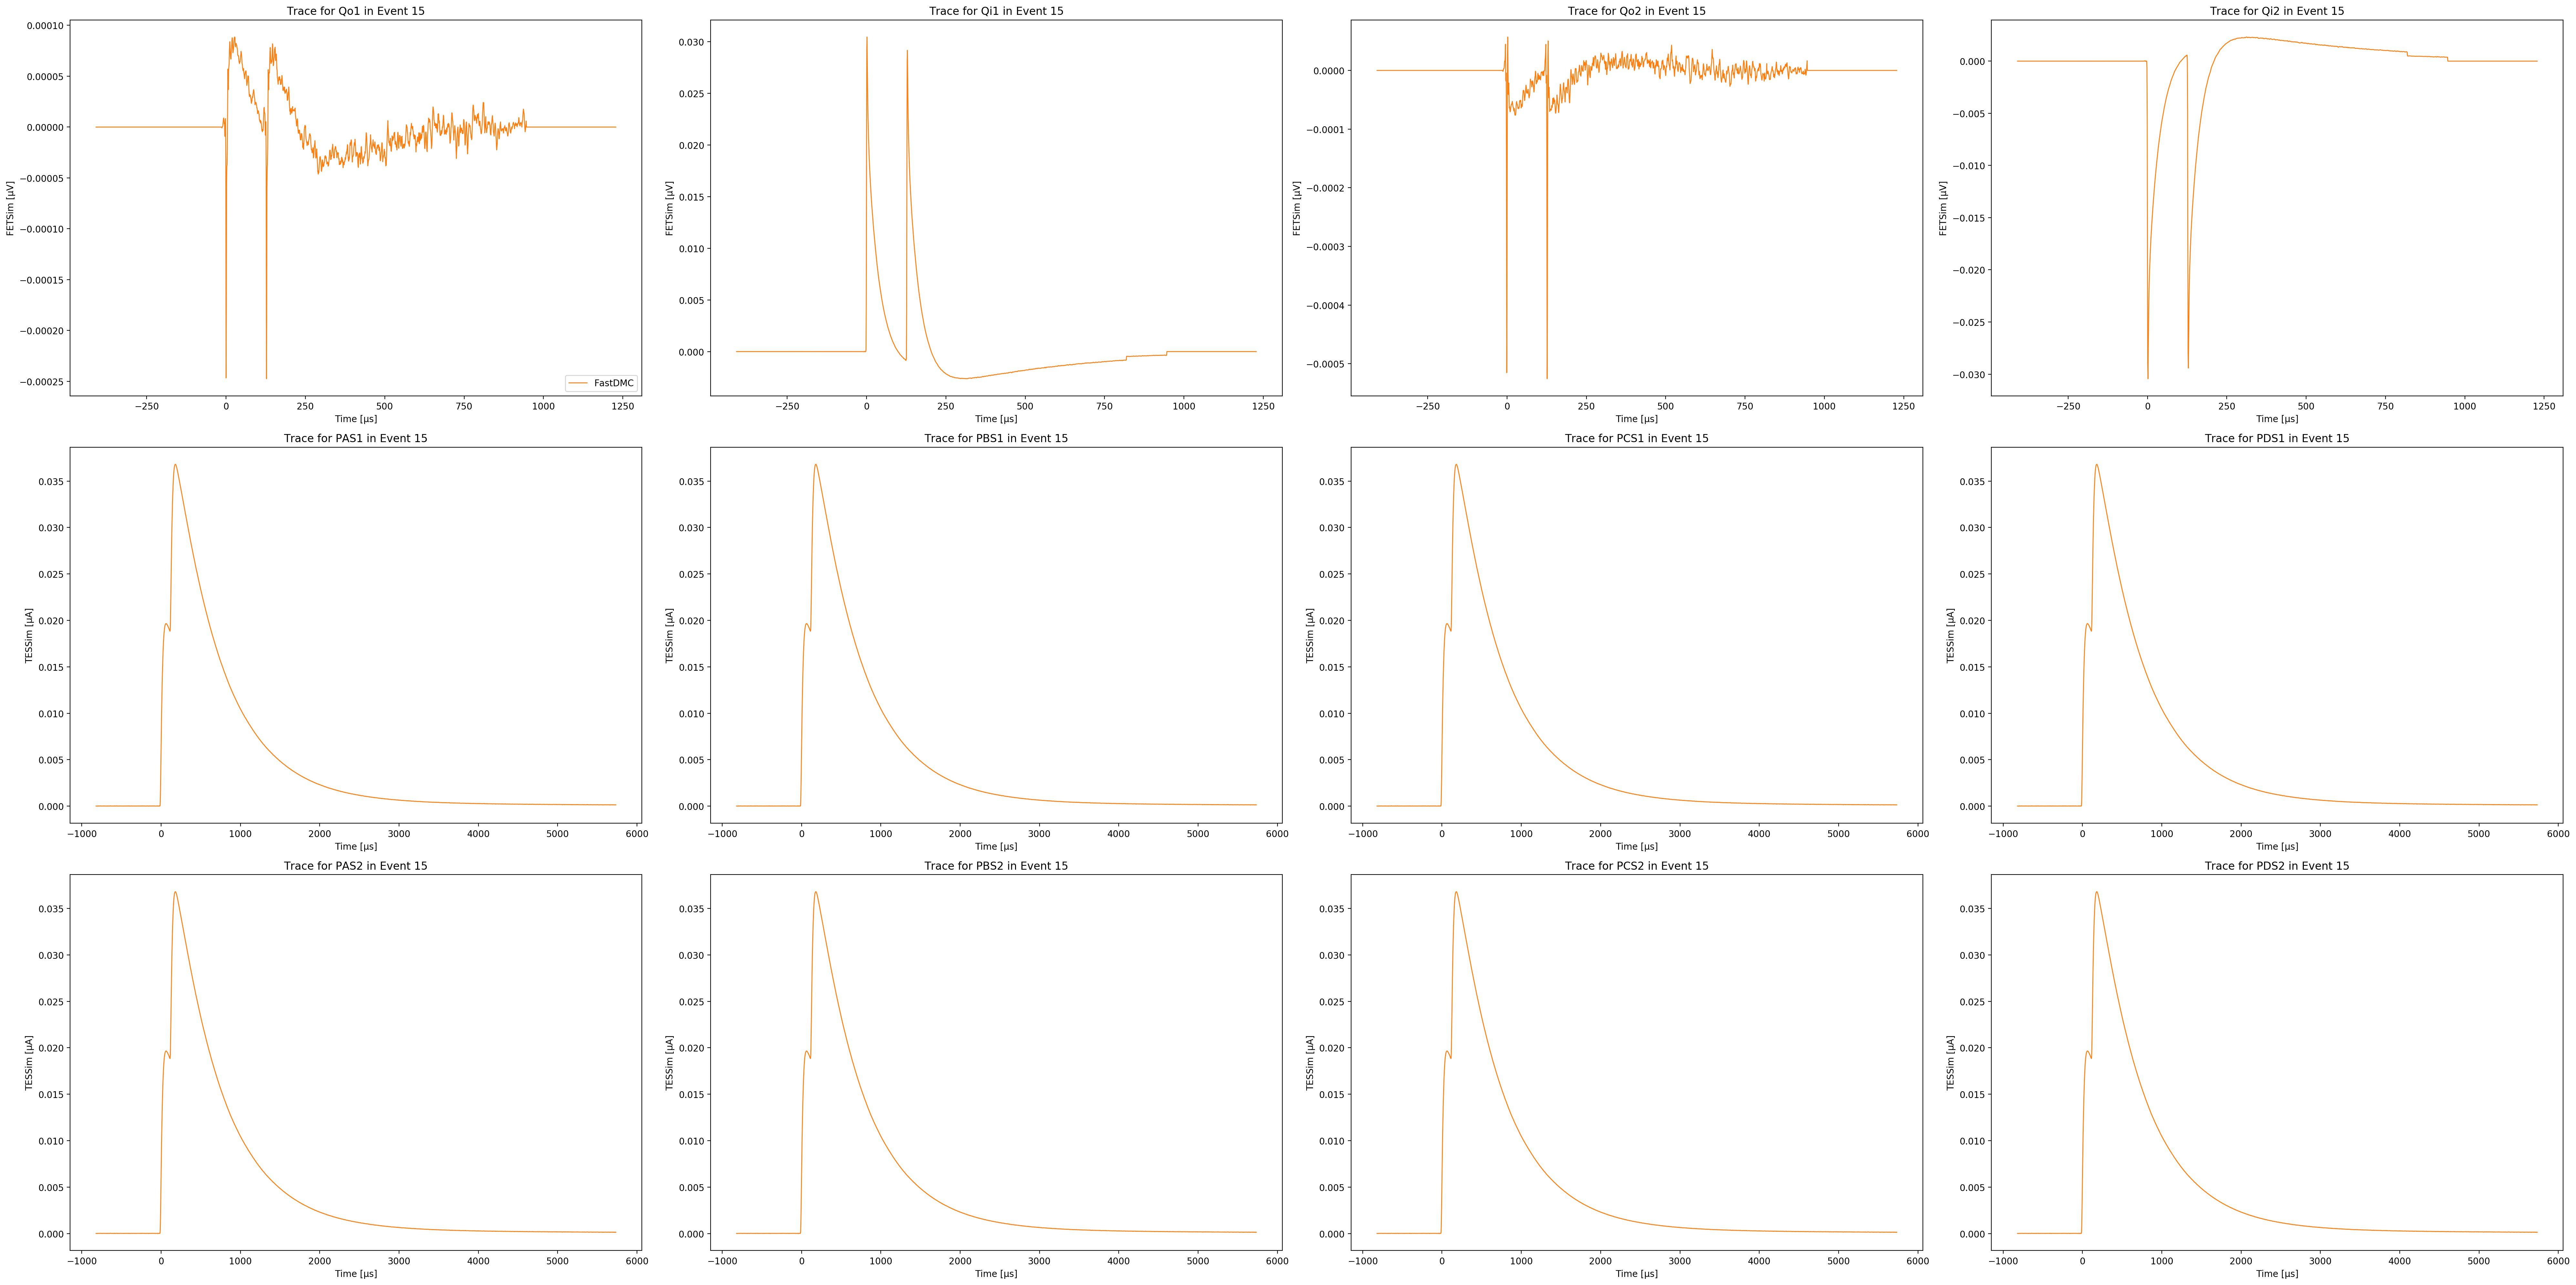

In [10]:
event = 15

#### All channels on one giant plot -- NOTE dimensions are Y x X
#### NOTE:  This is only good for an iZIP5 detector
fig1, axes = plt.subplots(3,4,figsize=(40,20), dpi = 200)
fig1.set_tight_layout(True)

# -----------------------------------------------------------------------------------------------------------------------------

# Do the four charge channels first, across the top
for plot in range(4):
    currentAxis = axes.flatten()[plot]
    currentAxis.plot(chargeBins, pileupFET[chargeChans[plot]][event], 
                     lw=1, color = 'C1', label='FastDMC')
    if plot==0: currentAxis.legend(loc="lower right")
    currentAxis.set_xlabel("Time [\u03BCs]")
    currentAxis.set_ylabel("FETSim [\u03BCV]")
    currentAxis.set_title('Trace for ' + chargeChans[plot] + ' in Event ' + str(event))

# Do the eight phonon channels, side 1 then side 2
for plot in range(4,12):
    currentAxis = axes.flatten()[plot]
    currentAxis.plot(phononBins, pileupTES[phononChans[plot-4]][event], 
                     lw=1, color = 'C1', label='FastDMC')

    currentAxis.set_xlabel("Time [\u03BCs]")
    currentAxis.set_ylabel("TESSim [\u03BCA]")
    currentAxis.set_title('Trace for ' + phononChans[plot-4] + ' in Event ' + str(event))

In [11]:
fig1.savefig("iZIP5_FastDMC.eps")
fig1.savefig("iZIP5_FastDMC.png")